---
CSC 268 Lab 8:  Component Labeling & Statistics
---

This lab will examine some of the tools available for connected component labeling and analysis.  We're using a new package here called `scikit-image`.  If you are running on your own computer via Anaconda you may need to install it to the current environment.

In [ ]:
import cv2 as cv
import numpy as np
from scipy.ndimage import label
from skimage.measure import regionprops, regionprops_table
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
mpl.rc('image', cmap='gray')

def imshow(img,cmap=None):
    plt.imshow(img,cmap=cmap,interpolation='none')
    plt.axis('off')
    plt.show()
    
birds = cv.imread('birds.jpg',0).astype(np.float32)/255.0
imshow(birds)
bb = birds < 0.9
imshow(bb)

Note that the positive areas of a binary image are indicated with a value of 1, which is rendered in white.  Thus the binary image shown above has white bird components on a black background.  We would like to separate these so that each one has a unique label.

SciPy's `label` function requires us to supply a _structuring element_, a matrix showing which neighbors are considered connected to the center pixel.  We can this creat a 4-connected labeling or an 8-connected one, among other options.

To display a label set, we display the label image as an indexed image.  Each label references a different color in the colormap.  By setting `vmin=1` we designate the background (label 0) as outside the valid range, and render it in black.  If we want to see just a single component, we can use a boolean test to make abinary image.

Because we have such a high resolution image, it is hard to see all the detail in each component without zooming in to a smaller portion of the image.

In [ ]:
def show_labels(lbl,nlbl=None,cmap='rainbow'):
    cmap = mpl.colormaps[cmap]
    cmap.set_under(color="black")
    plt.imshow(lbl,cmap=cmap,interpolation='none',vmin=1,vmax=nlbl)
    plt.axis('off')
    plt.show()
    
lbl,nlbl = label(bb,structure=np.ones((3,3)))
print(lbl.max(),nlbl)
show_labels(lbl,nlbl)
imshow(lbl==161)
imshow(birds[1200:1800,3200:4000])
show_labels(lbl[1200:1800,3200:4000],nlbl)
imshow(lbl[1200:1800,3200:4000]==161)
print(np.unique(lbl[1200:1800,3200:4000]))

We can use Scikit-image's `regionprops` function to analyze the components for various statistics.  In the example below, you will see that many components have very small area.  These are isolated pixels that happened to cross the threshold when we binarized the original image.  We probably want to remove those from consideration.

Once we have identified the regions we are interested in, we can compute various [geometric properties](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops) for them.  In the example below we plot the centroid of each component.  Note that in a few cases several birds overlap to form a single component.  When this happens the centroid will often fall between them.

We can also compute the bounding box of a region and use it to get a closely cropped sample from the original image.

[ 7168 14295     1     1     1     1     1    11  8977     1     1     2
     4     1     1     1     1     1     1     1     1     1     2     1
     1 10748 19388     1     1     3     1     1 26146     1     1     1
     2     1     1     1     1     1     2     1     1     1     2     2
     1     1     1     4 19579     1     2     1     2 18454     1     2
     1     1     1     1     1     2     1     1     1     9     1     1
     1     1     1 11630  8534     1     2     1     4     1     1     2
 10285     1     1     1     1 12224 10388 12508     1     1     1     1
     1     1     1     6     8     2     1     1     1 16132 11130     1
     2     1     1  9026     2     2 14562     3     1     1  9982     1
     2     3     1     1     1     1     1     1 12464     2     2 10465
 10822     1     2     1     2     2 12530 10959     2     1  9844     1
  8247  9765 10786 10975     1     6     1     1     1     1     2 18497
 27012 23940     1     1 12809     1     3     1   

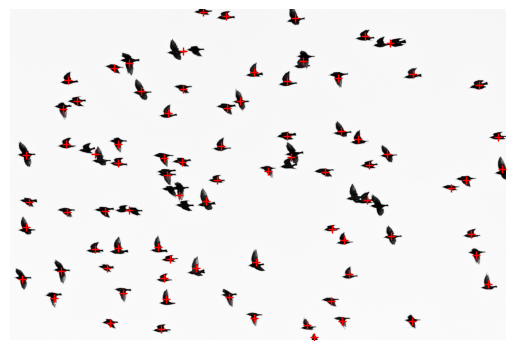

[ 202 3461  319 3662]


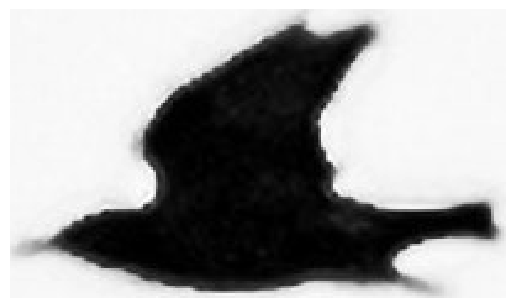

In [108]:
# two ways to get properties -- first uses lazy evaluation, second is eager
rgn = regionprops(lbl)
rgn_tbl = regionprops_table(lbl,properties=('area','perimeter','centroid','bbox','image_filled','eccentricity','orientation','axis_major_length','axis_minor_length','moments_hu','solidity'))

# figure out which components are birds
area = np.array([cc.area for cc in rgn])
print(area)
valid = area > 100  # anything smaller than this isn't an interesting component
v_id = np.array(np.where(valid))
print(v_id)
print(valid.sum())

# plot the centroids of all the significant components
centroid = np.array([cc.centroid for cc in rgn])
print(centroid.shape)
plt.imshow(birds)
plt.plot(centroid[valid,1],centroid[valid,0],'r+')
plt.axis('off')
plt.show()

# we can also read values out of the table
cx = rgn_tbl['centroid-0']
cy = rgn_tbl['centroid-1']

# bounding box gives coordinates of region around the component
bbox = np.array([cc.bbox for cc in rgn])
print(bbox[25])
imshow(birds[bbox[25][0]:bbox[25][2],bbox[25][1]:bbox[25][3]])  # closeup

66
254


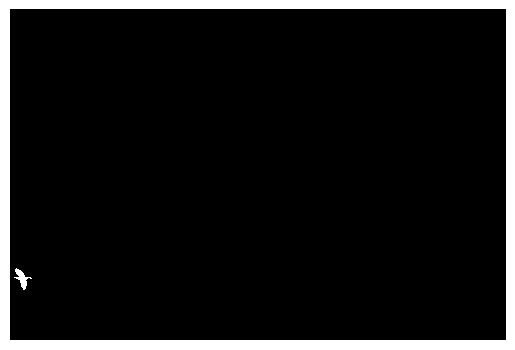

[2805 2114 2994 2285]


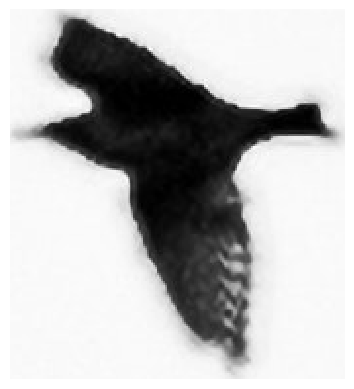

In [111]:
# TODO: Pick a bird in the lower left corner of the image.  Determine its label index.
# Print the centroid, and display a cropped image around it using the bounding box.

imshow(lbl==276)
print(bbox[276])
imshow(birds[bbox[276][0]:bbox[276][2],bbox[276][1]:bbox[276][3]])  # closeup

#print(np.argmin(cy[valid]-cx[valid]))
#print(v_id[0,66]+1)

OpenCV's `connectedComponentsWithStats` function also computes connected components of a binary image, along with a few common statistics.  It doesn't offer as many options.

In [ ]:
cv_nlbl,cv_lbl,cv_stat,cv_centroid = cv.connectedComponentsWithStats(bb.astype(np.uint8))
show_labels(cv_lbl)

# centroid computation is the same.  
# index differs by 1 because opencv includes the background as a component
print(cv_centroid[1],centroid[0])
print(cv_centroid[2],centroid[1])
print(cv_centroid[26],centroid[25])

# stats include the upper left coordinates of the bounding box, the height and width, 
# and the area of the component in pixels.  order of axes is reversed.
print(cv_stat[1],bbox[0],bbox[0][2:]-bbox[0][:2],area[0])
print(cv_stat[2],bbox[1],bbox[1][2:]-bbox[1][:2],area[1])
print(cv_stat[26],bbox[25],bbox[25][2:]-bbox[25][:2],area[2])

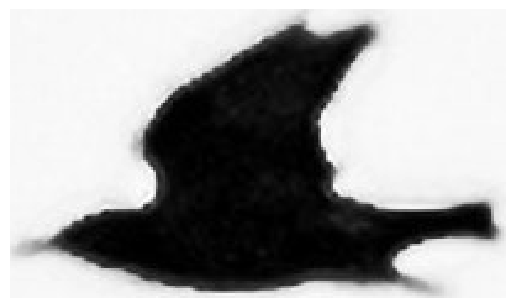

In [83]:
# TODO:  Use cv_stat to extract and display a cropped image around the a bird component of your choice.
imshow(birds[cv_stat[26][1]:cv_stat[26][1]+cv_stat[26][3],cv_stat[26][0]:cv_stat[26][0]+cv_stat[26][2]])